# MODEL CODE - UNIDIRECTIONAL RNN WITH LSTM CELLS

### Importing packages 

In [9]:
import numpy as np
from collections import OrderedDict
from itertools import chain
from rdkit import Chem
from sklearn.utils import shuffle
from matplotlib import pyplot as plt
import tensorflow as tf

### Example data

In [17]:
train_data = np.array(['CC1C2CCC(C2)C1CN(CCO)C(=O)c1ccc(Cl)cc1',
       'COc1ccc(-c2cc(=O)c3c(O)c(OC)c(OC)cc3o2)cc1O',
       'CCOC(=O)c1ncn2c1CN(C)C(=O)c1cc(F)ccc1-2',
       'Clc1ccccc1-c1nc(-c2ccncc2)no1',
       'CC(C)(Oc1ccc(Cl)cc1)C(=O)OCc1cccc(CO)n1'])

In [18]:
train_data[:5]

array(['CC1C2CCC(C2)C1CN(CCO)C(=O)c1ccc(Cl)cc1',
       'COc1ccc(-c2cc(=O)c3c(O)c(OC)c(OC)cc3o2)cc1O',
       'CCOC(=O)c1ncn2c1CN(C)C(=O)c1cc(F)ccc1-2',
       'Clc1ccccc1-c1nc(-c2ccncc2)no1',
       'CC(C)(Oc1ccc(Cl)cc1)C(=O)OCc1cccc(CO)n1'], dtype='<U43')

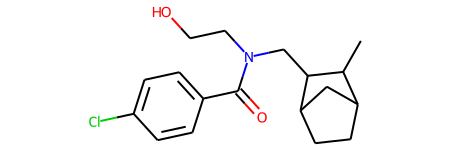

In [19]:
Chem.MolFromSmiles(train_data[0])

### Creating dictionary

In this part a dictionary is made that maps each unique character to an unique integer. 

In [20]:
unique_chars = sorted(list(OrderedDict.fromkeys(chain.from_iterable(train_data)))) #list of all unique characters

char_to_int = dict((c, i) for i, c in enumerate(unique_chars)) #dict from character to int. 
int_to_char = dict((i, c) for i, c in enumerate(unique_chars)) #dict from int to character.


#add E character to indicate end of SMILES
char_to_int.update({"E" : len(char_to_int)})
int_to_char.update({len(int_to_char) : "E"})

### One-hot encoding

Makes a 3D Numpy array for each sequence. This representation encodes each character in one-hot representation and adds 'endchar' symbol. It then returns two arrays; one for input sequence and the other for corresponding output.

In [21]:
def gen_data(data, int_to_char, char_to_int, embed):
    
    one_hot =  np.zeros((data.shape[0], embed+1, len(char_to_int)),dtype=np.int8)
    for i,smile in enumerate(data):
        for j,c in enumerate(smile):
            one_hot[i,j,char_to_int[c]] = 1
        one_hot[i,len(smile):,char_to_int["E"]] = 1 #addition of endchar
    return one_hot[:,0:-1,:], one_hot[:,1:,:] #input and output arrays

In [22]:
embed = max([len(seq) for seq in train_data]) #length of longest seq in dataset, so you know how much padding needs to be done.

In [26]:
#X: contains all characters except last of sequences
#Y: contains all characters except first of sequences
X, Y = gen_data(train_data, int_to_char, char_to_int, embed)
X, Y = shuffle(X, Y) #for randomization

### RNN model with LSTM cells

Model is built with two LSTM layers with dropout for sequence processing. Batch normalization is applied to input and intermediate layers to enhance training stability. We also use a softmax activation function in the output layer. The model structure is mimicked to be like that of the MORET PAPER. STILL NEEDS TO BE OPTIMIZED.

In [36]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, BatchNormalization
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import LSTM

model = Sequential()

model.add(BatchNormalization(input_shape=(None, X.shape[2])))

model.add(LSTM(512, input_shape=(None, X.shape[2]), return_sequences = True))
model.add(Dropout(0.25))

model.add(LSTM(256, return_sequences = True))
model.add(Dropout(0.25))

model.add(BatchNormalization())
model.add(Dense(Y.shape[-1], activation='softmax'))

print (model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_4 (Batch (None, None, 16)          64        
_________________________________________________________________
lstm_4 (LSTM)                (None, None, 512)         1083392   
_________________________________________________________________
dropout_4 (Dropout)          (None, None, 512)         0         
_________________________________________________________________
lstm_5 (LSTM)                (None, None, 256)         787456    
_________________________________________________________________
dropout_5 (Dropout)          (None, None, 256)         0         
_________________________________________________________________
batch_normalization_5 (Batch (None, None, 256)         1024      
_________________________________________________________________
dense_2 (Dense)              (None, None, 16)         

We then compile model using cross-entropy as loss function with Adam optimizer with learning rate of 0.001. and accuracy as the evaluation metric. STILL NEED TO SEE HOW ACCURACY WILL BE TAKEN INTO ACCOUNT. 

In [37]:
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam

model.compile(loss=categorical_crossentropy, optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

We then train the model and employ Early stopping to monitor trainin loss and minimize overfitting. The training is performed for a maximum of x epochs with a batch size of 256. This approach helps prevent overfitting and ensures the model stops when optimal performance is achieved.

In [34]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

#You monitor the loss of the model. This will if validation loss does not increase for 3 epochs. 
early_stopping = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)

history = model.fit(X, Y, epochs = 100, batch_size = 256, callbacks=[early_stopping])

Epoch 1/100
1/1 [==============================] - 0s 320ms/step - loss: 0.2045 - accuracy: 0.9488
Epoch 2/100
1/1 [==============================] - 0s 306ms/step - loss: 0.2156 - accuracy: 0.9442
Epoch 3/100
1/1 [==============================] - 0s 312ms/step - loss: 0.1984 - accuracy: 0.9442
Epoch 4/100
1/1 [==============================] - 0s 330ms/step - loss: 0.2049 - accuracy: 0.9395
Epoch 5/100
1/1 [==============================] - 0s 308ms/step - loss: 0.2008 - accuracy: 0.9442
Epoch 6/100
1/1 [==============================] - 0s 305ms/step - loss: 0.1982 - accuracy: 0.9442
Epoch 7/100
1/1 [==============================] - 0s 299ms/step - loss: 0.1902 - accuracy: 0.9488
Epoch 8/100
1/1 [==============================] - 0s 260ms/step - loss: 0.1800 - accuracy: 0.9535
Epoch 9/100
1/1 [==============================] - 0s 268ms/step - loss: 0.1720 - accuracy: 0.9442
Epoch 10/100
1/1 [==============================] - 0s 276ms/step - loss: 0.1600 - accuracy: 0.9581
Epoch 11/

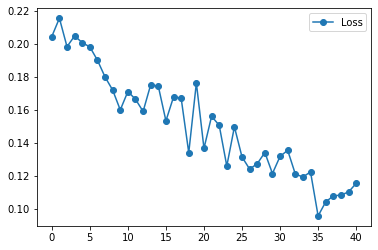

In [35]:
plt.plot(history.history["loss"], '-o', label="Loss")
plt.legend()